# 01 - Data Exploration

## Objective
Explore the customer churn dataset to understand:
- Feature distributions
- Class balance of target variable
- Data quality issues
- Feature correlations

## Dataset
Using sample data generated by `create_sample_data()` for development.
Replace with actual customer data CSV in production.

In [1]:
# Install required packages (run once)
# Install the local churn-prediction package in development mode
%pip install -e .. --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import create_sample_data, get_data_summary, validate_data
from src.preprocessing import identify_column_types

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('Libraries loaded successfully')

Libraries loaded successfully


In [3]:
# Generate sample data for exploration
# In production, replace with: df = load_data('data/customers.csv')
RANDOM_STATE = 42
df = create_sample_data(n_samples=5000, random_state=RANDOM_STATE, churn_rate=0.2)

print(f'Dataset shape: {df.shape}')
print(f'Columns: {list(df.columns)}')

Dataset shape: (5000, 7)
Columns: ['customer_id', 'tenure', 'monthly_charges', 'total_charges', 'contract', 'payment_method', 'churn']


## 2. Data Overview

In [4]:
# Display first few rows
df.head(10)

,customer_id,tenure,monthly_charges,total_charges,contract,payment_method,churn
0,CUST_01501,49,75.13,3615.05,Two year,Electronic check,0
1,CUST_02586,62,44.21,2480.90,Month-to-month,Credit card,0
2,CUST_02653,41,76.08,3512.26,Two year,Electronic check,0
3,CUST_01055,25,59.96,1301.95,One year,Credit card,0
4,CUST_00705,17,87.09,1633.89,Month-to-month,Credit card,1
5,CUST_00106,15,48.53,791.94,Month-to-month,Credit card,0
6,CUST_00589,3,60.53,192.99,Month-to-month,Electronic check,1
7,CUST_02468,19,24.28,456.93,Month-to-month,Mailed check,0
8,CUST_02413,28,76.33,2558.11,Month-to-month,Bank transfer,0
9,CUST_01600,39,68.37,2564.18,Month-to-month,Bank transfer,0


In [5]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      5000 non-null   object 
 1   tenure           5000 non-null   int64  
 2   monthly_charges  5000 non-null   float64
 3   total_charges    5000 non-null   float64
 4   contract         5000 non-null   object 
 5   payment_method   5000 non-null   object 
 6   churn            5000 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 273.6+ KB


In [6]:
# Descriptive statistics for numerical columns
df.describe()

,tenure,monthly_charges,total_charges,churn
count,5000.000000,5000.000000,5000.000000,5000.00000
mean,35.850800,59.925082,2156.263218,0.20000
std,20.326839,23.084262,1580.252112,0.40004
min,1.000000,20.050000,100.000000,0.00000
25%,18.000000,40.380000,879.975000,0.00000
50%,36.000000,60.205000,1809.285000,0.00000
75%,54.000000,79.792500,3121.675000,0.00000
max,71.000000,99.990000,7826.260000,1.00000


In [7]:
# Get data summary using our utility function
summary = get_data_summary(df)
print('Data Summary:')
for key, value in summary.items():
    print(f'  {key}: {value}')

Data Summary:
  shape: (5000, 7)
  columns: ['customer_id', 'tenure', 'monthly_charges', 'total_charges', 'contract', 'payment_method', 'churn']
  dtypes: {'customer_id': 'object', 'tenure': 'int64', 'monthly_charges': 'float64', 'total_charges': 'float64', 'contract': 'object', 'payment_method': 'object', 'churn': 'int64'}
  null_counts: {'customer_id': 0, 'tenure': 0, 'monthly_charges': 0, 'total_charges': 0, 'contract': 0, 'payment_method': 0, 'churn': 0}
  null_percentages: {'customer_id': 0.0, 'tenure': 0.0, 'monthly_charges': 0.0, 'total_charges': 0.0, 'contract': 0.0, 'payment_method': 0.0, 'churn': 0.0}
  target_distribution: {0: 4000, 1: 1000}


## 3. Target Variable Analysis (Churn)

In [8]:
# Check class balance
churn_counts = df['churn'].value_counts()
churn_pct = df['churn'].value_counts(normalize=True) * 100

print('Churn Distribution:')
print(f'  Retained (0): {churn_counts[0]:,} ({churn_pct[0]:.1f}%)')
print(f'  Churned (1):  {churn_counts[1]:,} ({churn_pct[1]:.1f}%)')
print(f'\nChurn Rate: {churn_pct[1]:.2f}%')

Churn Distribution:
  Retained (0): 4,000 (80.0%)
  Churned (1):  1,000 (20.0%)

Churn Rate: 20.00%


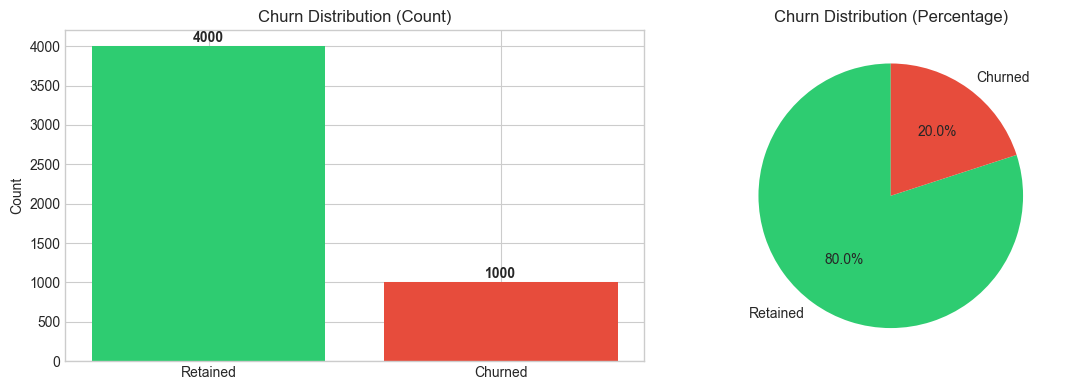

In [9]:
# Visualize class balance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Retained', 'Churned'], churn_counts.values, color=colors)
axes[0].set_ylabel('Count')
axes[0].set_title('Churn Distribution (Count)')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(churn_counts.values, labels=['Retained', 'Churned'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Churn Distribution (Percentage)')

plt.tight_layout()
plt.savefig('../models/churn_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Feature Distributions

In [10]:
# Identify column types
col_types = identify_column_types(df)
print(f'Numerical columns: {col_types["numerical"]}')
print(f'Categorical columns: {col_types["categorical"]}')

Numerical columns: ['tenure', 'monthly_charges', 'total_charges']
Categorical columns: ['contract', 'payment_method']


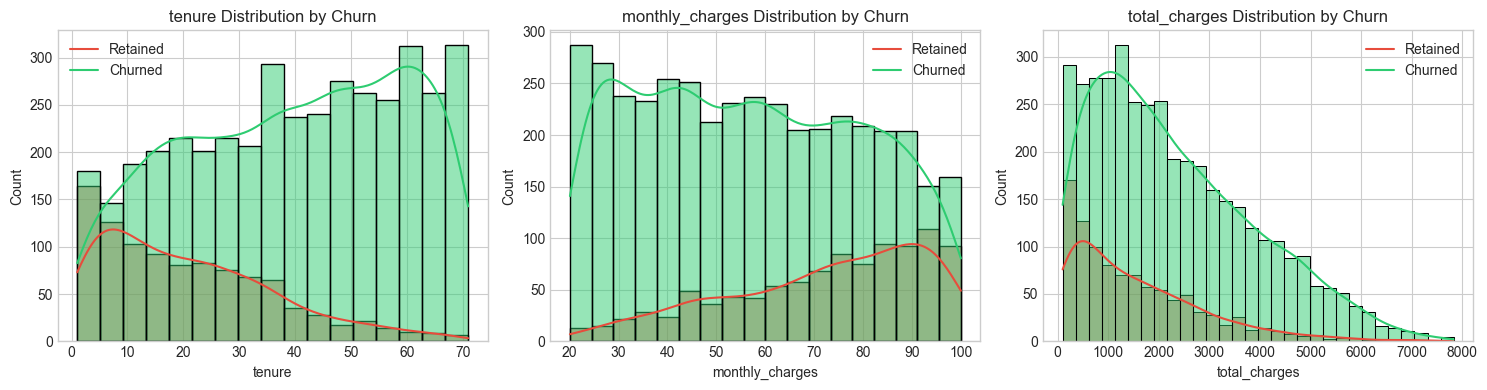

In [11]:
# Distribution of numerical features
numerical_cols = col_types['numerical']

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(5*len(numerical_cols), 4))
if len(numerical_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, numerical_cols):
    # Plot histogram with KDE
    sns.histplot(data=df, x=col, hue='churn', kde=True, ax=ax, palette=colors)
    ax.set_title(f'{col} Distribution by Churn')
    ax.legend(['Retained', 'Churned'])

plt.tight_layout()
plt.savefig('../models/numerical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

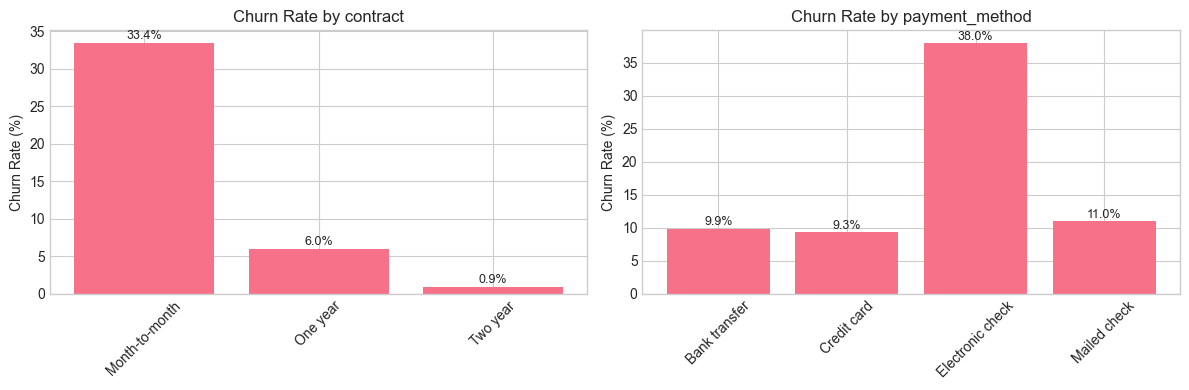

In [12]:
# Distribution of categorical features
categorical_cols = col_types['categorical']

fig, axes = plt.subplots(1, len(categorical_cols), figsize=(6*len(categorical_cols), 4))
if len(categorical_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, categorical_cols):
    # Calculate churn rate by category
    churn_by_cat = df.groupby(col)['churn'].agg(['sum', 'count'])
    churn_by_cat['rate'] = churn_by_cat['sum'] / churn_by_cat['count'] * 100
    
    # Plot
    bars = ax.bar(churn_by_cat.index, churn_by_cat['rate'])
    ax.set_ylabel('Churn Rate (%)')
    ax.set_title(f'Churn Rate by {col}')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, rate in zip(bars, churn_by_cat['rate']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{rate:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../models/categorical_churn_rates.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Data Quality Assessment

In [13]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

print('Missing Values Analysis:')
print(missing_df[missing_df['Missing Count'] > 0] if missing.sum() > 0 else 'No missing values found!')

Missing Values Analysis:
No missing values found!


In [14]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
duplicate_id_count = df['customer_id'].duplicated().sum()

print(f'Duplicate rows: {duplicate_count}')
print(f'Duplicate customer IDs: {duplicate_id_count}')

Duplicate rows: 0
Duplicate customer IDs: 0


In [15]:
# Run validation
validation_report = validate_data(df)
print('Validation Report:')
print(f'  Rows: {validation_report["rows"]:,}')
print(f'  Columns: {validation_report["columns"]}')
print(f'  Passed: {validation_report["passed"]}')

Validation Report:
  Rows: 5,000
  Columns: 7
  Passed: True


In [16]:
# Check for outliers in numerical columns
print('Outlier Analysis (values beyond 3 standard deviations):')
for col in numerical_cols:
    mean = df[col].mean()
    std = df[col].std()
    lower = mean - 3 * std
    upper = mean + 3 * std
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f'  {col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)')

Outlier Analysis (values beyond 3 standard deviations):
  tenure: 0 outliers (0.00%)
  monthly_charges: 0 outliers (0.00%)
  total_charges: 24 outliers (0.48%)


## 6. Correlation Analysis

In [17]:
# Correlation matrix for numerical features
correlation_cols = numerical_cols + ['churn']
corr_matrix = df[correlation_cols].corr()

# Display correlation with target
print('Correlation with Churn:')
target_corr = corr_matrix['churn'].drop('churn').sort_values(key=abs, ascending=False)
print(target_corr)

Correlation with Churn:
tenure            -0.359334
monthly_charges    0.258002
total_charges     -0.186016
Name: churn, dtype: float64


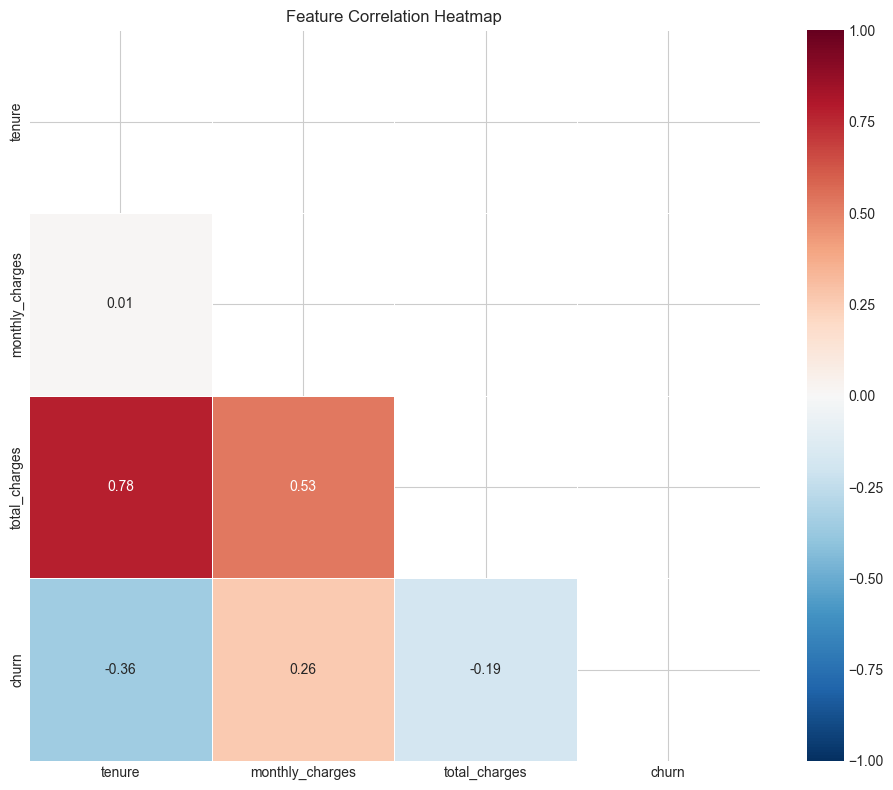

In [18]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('../models/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Findings Summary

### Dataset Overview
- **Samples**: 5,000 customers
- **Features**: 6 (3 numerical, 2 categorical, 1 ID)
- **Target**: Binary churn indicator

### Class Balance
- **Churn Rate**: ~20% (imbalanced dataset)
- Consider stratified sampling for train/test splits
- May need class weighting or SMOTE for model training

### Data Quality
- No missing values detected
- No duplicate records
- All required columns present

### Feature Insights
- Numerical features show different distributions between churned/retained
- Categorical features may have predictive power based on churn rate variance

### Next Steps
1. Proceed with preprocessing pipeline
2. Train baseline logistic regression model
3. Evaluate with proper cross-validation

In [19]:
print('Data exploration complete!')
print(f'\nDataset is ready for modeling:')
print(f'  - {len(df):,} samples')
print(f'  - {len(numerical_cols)} numerical features')
print(f'  - {len(categorical_cols)} categorical features')
print(f'  - {df["churn"].mean()*100:.1f}% churn rate')

Data exploration complete!

Dataset is ready for modeling:
  - 5,000 samples
  - 3 numerical features
  - 2 categorical features
  - 20.0% churn rate
